In [222]:
import numpy as np
import matplotlib.pyplot as plt

def generate_classification_toy_data(n_train=200, mean_a=np.asarray([0, 0]), std_dev_a=1, mean_b=3, std_dev_b=0.5):

    # positive examples are distributed normally
    X1 = (np.random.randn(n_train, 2)*std_dev_a+mean_a).T

    # negative examples have a "ring"-like form
    r = np.random.randn(n_train)*std_dev_b+mean_b
    angle = np.random.randn(n_train)*2*np.pi
    X2 = np.array([r*np.cos(angle)+mean_a[0], r*np.sin(angle)+mean_a[1]])

    # stack positive and negative examples in a single array
    X_train = np.hstack((X1,X2))

    # label positive examples with +1, negative with -1
    y_train = np.zeros(n_train*2)
    y_train[:n_train] = 1
    y_train[n_train:] = -1
    return X_train, y_train


def plot_binary_data(X_train, y_train):
    plt.plot(X_train[0, np.argwhere(y_train == 1)], X_train[1, np.argwhere(y_train == 1)], 'ro')
    plt.plot(X_train[0, np.argwhere(y_train == -1)], X_train[1, np.argwhere(y_train == -1)], 'bo')

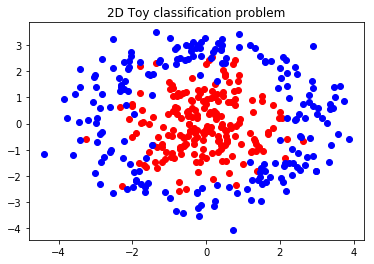

(100,)


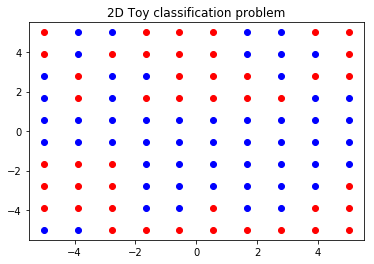

[[  4.97930528e-01]
 [  4.81209726e-01]
 [  4.11878475e-01]
 [  2.50694619e-01]
 [  1.09360546e-01]
 [  1.05435988e-01]
 [  2.39813882e-01]
 [  4.15218157e-01]
 [  4.85807185e-01]
 [  4.98756889e-01]
 [  4.71746609e-01]
 [  3.05628217e-01]
 [  4.26113863e-02]
 [  1.09138343e-03]
 [  3.84256279e-05]
 [  4.63647399e-05]
 [  1.25820641e-03]
 [  4.86012314e-02]
 [  3.24838026e-01]
 [  4.78495356e-01]
 [  3.35538004e-01]
 [  2.49897487e-02]
 [  1.15244713e-05]
 [  3.81220516e-09]
 [  5.79723011e-10]
 [  2.42742731e-10]
 [  1.40567590e-09]
 [  4.82329781e-06]
 [  1.94334090e-02]
 [  3.58938244e-01]
 [  1.28948873e-01]
 [  3.47566438e-04]
 [  3.37550548e-09]
 [  3.38996231e-11]
 [  3.48325513e-08]
 [  1.88243025e-09]
 [  3.06536687e-13]
 [  2.09144530e-10]
 [  1.11492195e-04]
 [  1.51845820e-01]
 [  5.58738604e-02]
 [  2.07402586e-05]
 [  1.49489492e-09]
 [  1.80697387e-08]
 [  2.02733464e-04]
 [  1.19147836e-04]
 [  1.93819046e-09]
 [  4.33214227e-11]
 [  2.55680548e-06]
 [  4.80283272e-02]


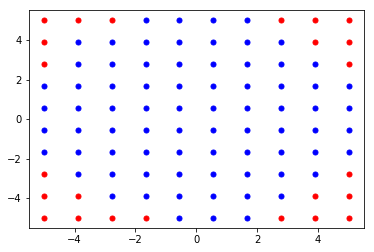

In [228]:
from scipy.linalg import fractional_matrix_power

def kernel(a, b, param = 1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

def newtons_method(x_init, a):
    return 0
    
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

## we assume f_prior_cpvariance function to be the kernel function
X_train, y_train = generate_classification_toy_data()

n = 10
Xtest1 = np.linspace(-5, 5, n).reshape(-1,1)
Xtest2 = np.linspace(-5, 5, n).reshape(-1,1)
X1, X2 = np.meshgrid(Xtest1, Xtest2)

X_test = np.hstack([X1.reshape(-1,1), X2.reshape(-1,1)]).T

K = kernel(X_train.T, X_train.T, 1)
K_ss = kernel(X_test.T, X_test.T, 1)
K_s = kernel(X_train.T, X_test.T, 1)

#print K.shape
#print K_ss.shape
#print K_s.shape

plot_binary_data(X_train, y_train)
#plt.plot(X_test[0], X_test[1], 'go')
_=plt.title("2D Toy classification problem")
plt.show()

f_sample_test = np.random.multivariate_normal(np.zeros(n*n), K_ss)
f_sample_prob = sigmoid(f_sample_test)

## Just based on prior covariance and mean
a = (np.round(f_sample_prob))
print a.shape
#plot_binary_data(X_train, y_train)
plt.plot(X_test[0,a == 0], X_test[1, a == 0], 'bo')
plt.plot(X_test[0,a == 1], X_test[1, a == 1], 'ro')
_=plt.title("2D Toy classification problem")
plt.show()

## Finding Posterior
def laplace_approximation(K, y_train):
    
    f = np.zeros(K.shape[0]).reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    num_iteration = 20
    I = np.eye(K.shape[0])
    
    i = 0
    while i < num_iteration:
        sig = sigmoid(f)
        dia = sig*(1.0 - sig)
        #print dia.shape
        W = np.diag(dia[:,0])
        W_half = fractional_matrix_power(W, 0.5)
        L = np.linalg.cholesky(I + np.multiply(W_half, np.multiply(K, W_half)))
        b = np.matmul(W, f) + y_train - sig
        d = np.linalg.solve(L, np.matmul(W_half, np.matmul(K, b)))
        a = b - np.matmul(W_half, np.linalg.solve(L.T, d))
        f = np.matmul(K, a)
        
        i += 1
    
    return f

f_hat = laplace_approximation(K, y_train)
#print f_hat

def get_posterior(f_fin, X_train, y_train, X_test):
    
    y_train = y_train.reshape(-1,1)
    I = np.eye(K.shape[0])
    
    sig = sigmoid(f_hat)
    dia = sig*(1.0 - sig)
    W = np.diag(dia[:,0])
    W_half = fractional_matrix_power(W, 0.5)
    L = np.linalg.cholesky(I + np.multiply(W_half, np.multiply(K, W_half)))
    fs_mean = np.matmul(K_s.T, (y_train - sig))
    #print fs_mean.shape
    v = np.linalg.solve(L, np.matmul(W_half, K_s))
    V = K_ss - np.matmul(v.T, v)
    r = (1.0*fs_mean)/(np.sqrt(1.0 + (np.pi * np.diagonal(V))/8.0)).reshape(-1,1)
    pi_s = sigmoid(r)
    return pi_s

pi_s = get_posterior(f_fin, X_train, y_train, X_test)
print pi_s

posterior = np.round(np.array(2*pi_s[:, 0]))

plt.plot(X_test[0,posterior == 0], X_test[1, posterior == 0], 'bo', ms = 5)
plt.plot(X_test[0,posterior >= 1], X_test[1, posterior >= 1 ], 'ro', ms = 5)
plt.show()

In [117]:
f = np.zeros(100).reshape(-1,1)

sig = sigmoid(f)
dia = sig*(1.0 - sig)
print dia.shape
np.diag(dia[:,0])

(100, 1)


array([[ 0.25,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25, ...,  0.  ,  0.  ,  0.  ],
       ..., 
       [ 0.  ,  0.  ,  0.  , ...,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.25]])